In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

plt.style.use('fivethirtyeight') #A style sheet to make things look prettier

In [161]:
data_path = './Data/SteamCharts 2.csv'
df = pd.read_csv(data_path, encoding='unicode_escape') # Needs special encoding to read the file

In [162]:
df.head() #outputs the first few lines of data

,gamename,year,month,avg,gain,peak,avg_peak_perc
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%
1,Counter-Strike: Global Offensive,2021,January,743209.66,25405.91,1124553,66.0893%
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%


In [163]:
df['month'][0]  #outputs the month at data #0

'February '

In [164]:
month_to_num = { #Encodes Months into numbers
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

df['month'] = df['month'].str.strip() # Strip whitespace
df['month'] = df['month'].map(month_to_num) # Map month names to numbers
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)

In [165]:
df.info() #outputs columns, non-null data, & Data type

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45947 entries, 2021-02-01 to 2014-04-01
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gamename       45947 non-null  object 
 1   year           45947 non-null  int64  
 2   month          45947 non-null  int64  
 3   avg            45947 non-null  float64
 4   gain           45191 non-null  float64
 5   peak           45947 non-null  int64  
 6   avg_peak_perc  45946 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 2.8+ MB


In [166]:
df.describe()

,year,month,avg,gain,peak
count,45947.000000,45947.000000,4.594700e+04,45191.000000,4.594700e+04
mean,2017.413172,6.548959,4.963317e+03,-14.512972,9.695132e+03
std,2.245278,3.520560,3.561798e+04,5118.614961,6.739034e+04
min,2012.000000,1.000000,0.000000e+00,-250248.990000,0.000000e+00
25%,2016.000000,3.000000,1.948400e+02,-95.395000,4.640000e+02
50%,2018.000000,7.000000,5.994200e+02,-4.100000,1.319000e+03
75%,2019.000000,10.000000,1.757095e+03,61.800000,3.842000e+03
max,2021.000000,12.000000,1.584887e+06,426446.120000,3.236027e+06


In [167]:
df.isna().sum() #sum of data with null

gamename           0
year               0
month              0
avg                0
gain             756
peak               0
avg_peak_perc      1
dtype: int64

For every month with a previous documented month we can calculate the gain from avg. With the rest of them we can use an imputer.

In [168]:
df['gain'] = df['avg'].pct_change().fillna(df['gain']) * 100

df.isna().sum() #output new null count

gamename          0
year              0
month             0
avg               0
gain             16
peak              0
avg_peak_perc     1
dtype: int64

In [169]:
print(df['gain'].unique()) #Output unique values in gain

[-2.19642000e+05  2.96407659e-01 -3.41840417e+00 ... -7.26289466e+01
 -2.25520321e+01  2.08003809e+01]


In [170]:
df['gain'] = df['gain'].replace([np.inf, -np.inf], np.nan) #for handling infinite values in datasets before further processing or analysis.

In [171]:
imputer = KNNImputer(n_neighbors=2) #creates an imputer object that uses the k-Nearest Neighbors algorithm to fill in missing values in a dataset
#the imputer will consider the two nearest neighbors to the missing value when filling it in.

df_gain= imputer.fit_transform(df[['gain']])
df['gain'] = df_gain

df#outputs

,gamename,year,month,avg,gain,peak,avg_peak_perc
date,,,,,,,
2021-02-01,Counter-Strike: Global Offensive,2021,2,741013.24,-219642.000000,1123485,65.9567%
2021-01-01,Counter-Strike: Global Offensive,2021,1,743209.66,0.296408,1124553,66.0893%
2020-12-01,Counter-Strike: Global Offensive,2020,12,717803.75,-3.418404,1164396,61.646%
2020-11-01,Counter-Strike: Global Offensive,2020,11,668754.58,-6.833228,1037464,64.4605%
2020-10-01,Counter-Strike: Global Offensive,2020,10,613666.69,-8.237385,943876,65.0156%
...,...,...,...,...,...,...,...
2014-08-01,Defiance,2014,8,3593.53,132.664729,8669,41.4526%
2014-07-01,Defiance,2014,7,1783.49,-50.369414,11263,15.8349%
2014-06-01,Defiance,2014,6,488.16,-72.628947,986,49.5091%


Text(0.5, 1.0, 'Gain of Steam Games Popularity')

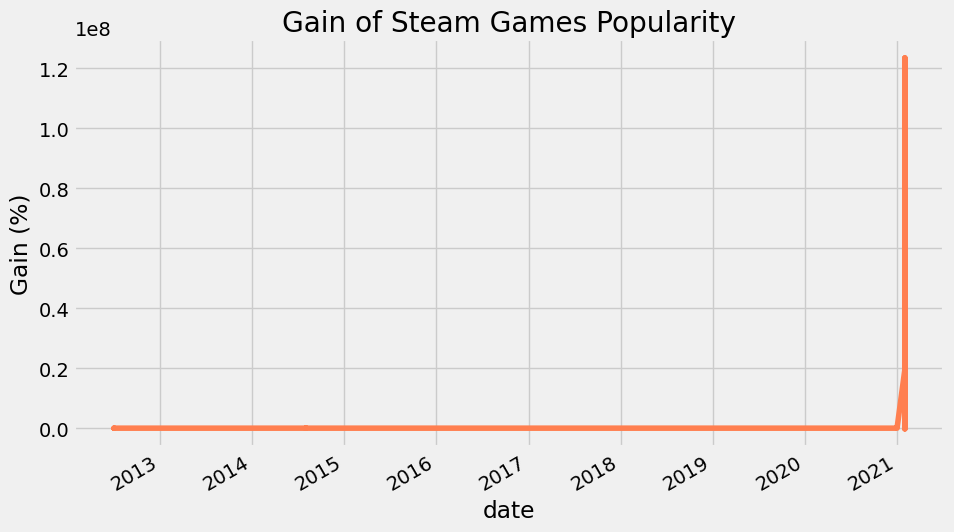

In [172]:
fig, ax = plt.subplots(figsize=(10, 6))

df['gain'].plot(ax=ax, color='coral', label='Gain')
ax.set_ylabel('Gain (%)')
ax.set_title('Gain of Steam Games Popularity')
#Graph of gain of steam games popularity

In [173]:
mean_gain = df['gain'].mean() #Mean of dataset in gain
std_gain = df['gain'].std() #std of dataset in gain
threshold = 3

outliers = df[(df['gain'] - mean_gain).abs() / std_gain > threshold] #identifying outliers in the DataFrame defined by the mean and std

df.drop(outliers.index, inplace=True) #Drops outliers

Text(0.5, 1.0, 'Gain of Steam Games Popularity')

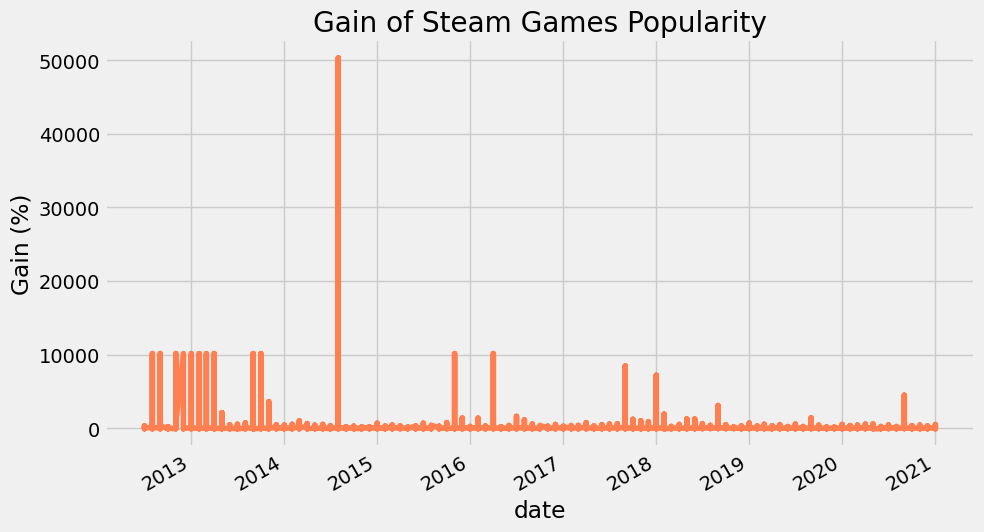

In [174]:
fig, ax = plt.subplots(figsize=(10, 6))

df['gain'].plot(ax=ax, color='coral', label='Gain')
ax.set_ylabel('Gain (%)')
ax.set_title('Gain of Steam Games Popularity')
#New graph of steam games popularity w/ no outliers

In [175]:
mean_gain = df['avg'].mean()
std_gain = df['avg'].std()
threshold = 3

outliers = df[(df['avg'] - mean_gain).abs() / std_gain > threshold] #identifying outliers in the DataFrame defined by the mean and std

print(len(outliers)) #Prints how many outliers there are

235


Text(0.5, 1.0, 'Average Players of Steam Games')

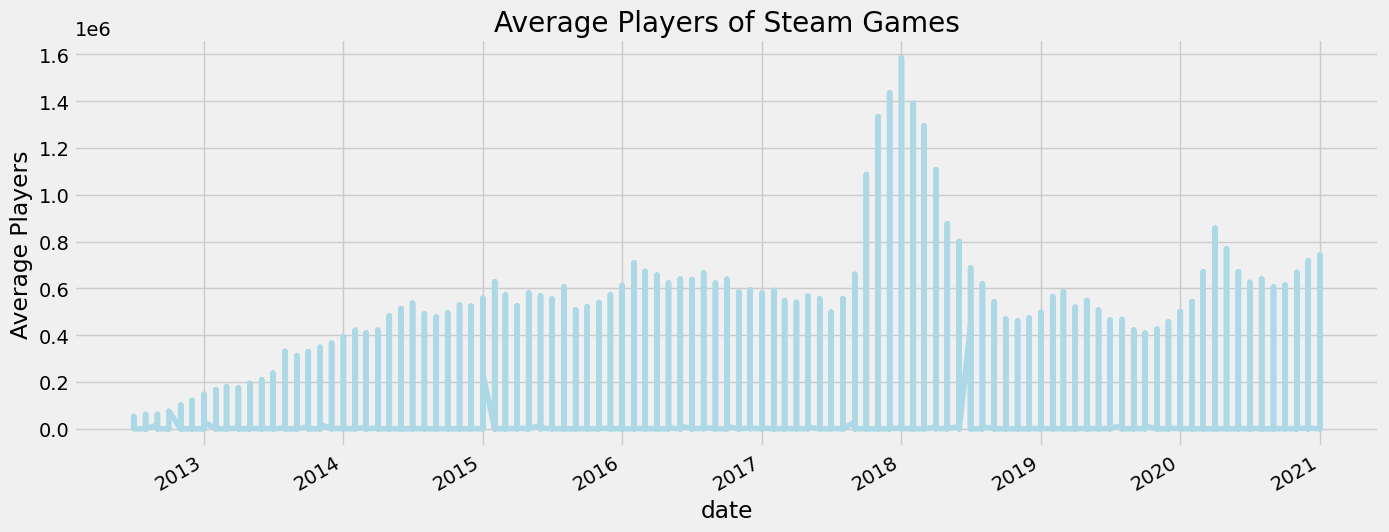

In [176]:
fig, ax = plt.subplots(figsize=(15, 6))

df['avg'].plot(ax=ax, color='lightblue', label='Average Players')
ax.set_ylabel('Average Players')
ax.set_title('Average Players of Steam Games')
#Average players of steam games graph w/o outliers

In [177]:
threshold = 30
z_scores = (df['avg'] - mean_gain) / std_gain #Get z-score

df['avg'] = np.where(z_scores > threshold, mean_gain + threshold * std_gain, #updates the 'avg' column of the DataFrame based on the values of z-scores
                            np.where(z_scores < -threshold, mean_gain - threshold * std_gain, df['avg'])) #depending on whether the z-score is above or below certain thresholds.

In [178]:
df['gamename'].unique().size #calculates and returns the number of unique game names present in the DataFrame


757

In [179]:
encoder = ce.BinaryEncoder(cols=['gamename']) #The encoder will encode the categories

df_encoded = encoder.fit_transform(df['gamename']) #transforming the categorical values into binary-encoded numerical values

df = pd.concat([df.drop('gamename', axis=1), df_encoded], axis=1) #drops the column along the specified axis, then concatenates
df
#gamename column replaced with its binary-encoded representation.

,year,month,avg,gain,peak,avg_peak_perc,gamename_0,gamename_1,gamename_2,gamename_3,gamename_4,gamename_5,gamename_6,gamename_7,gamename_8,gamename_9
date,,,,,,,,,,,,,,,,
2021-01-01,2021,1,743209.66,0.296408,1124553,66.0893%,0,0,0,0,0,0,0,0,0,1
2020-12-01,2020,12,717803.75,-3.418404,1164396,61.646%,0,0,0,0,0,0,0,0,0,1
2020-11-01,2020,11,668754.58,-6.833228,1037464,64.4605%,0,0,0,0,0,0,0,0,0,1
2020-10-01,2020,10,613666.69,-8.237385,943876,65.0156%,0,0,0,0,0,0,0,0,0,1
2020-09-01,2020,9,606850.32,-1.110761,977769,62.0648%,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-01,2014,8,3593.53,132.664729,8669,41.4526%,1,0,1,1,1,1,0,1,0,1
2014-07-01,2014,7,1783.49,-50.369414,11263,15.8349%,1,0,1,1,1,1,0,1,0,1
2014-06-01,2014,6,488.16,-72.628947,986,49.5091%,1,0,1,1,1,1,0,1,0,1


In [180]:
df['avg_peak_perc'] = df['avg_peak_perc'].str.rstrip('%').astype(float) / 100
#DataFrame df will contain floating-point numbers representing the percentage values divided by 100.
df

,year,month,avg,gain,peak,avg_peak_perc,gamename_0,gamename_1,gamename_2,gamename_3,gamename_4,gamename_5,gamename_6,gamename_7,gamename_8,gamename_9
date,,,,,,,,,,,,,,,,
2021-01-01,2021,1,743209.66,0.296408,1124553,0.660893,0,0,0,0,0,0,0,0,0,1
2020-12-01,2020,12,717803.75,-3.418404,1164396,0.616460,0,0,0,0,0,0,0,0,0,1
2020-11-01,2020,11,668754.58,-6.833228,1037464,0.644605,0,0,0,0,0,0,0,0,0,1
2020-10-01,2020,10,613666.69,-8.237385,943876,0.650156,0,0,0,0,0,0,0,0,0,1
2020-09-01,2020,9,606850.32,-1.110761,977769,0.620648,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-01,2014,8,3593.53,132.664729,8669,0.414526,1,0,1,1,1,1,0,1,0,1
2014-07-01,2014,7,1783.49,-50.369414,11263,0.158349,1,0,1,1,1,1,0,1,0,1
2014-06-01,2014,6,488.16,-72.628947,986,0.495091,1,0,1,1,1,1,0,1,0,1


In [181]:
scaled_rows = ['gain', 'avg', 'peak', 'avg_peak_perc']
scaler = StandardScaler()
df[scaled_rows] = scaler.fit_transform(df[scaled_rows]) #transforms the data such that it has a mean of 0 and a standard deviation of 1.

df.head() #Print the first few lines of data

,year,month,avg,gain,peak,avg_peak_perc,gamename_0,gamename_1,gamename_2,gamename_3,gamename_4,gamename_5,gamename_6,gamename_7,gamename_8,gamename_9
date,,,,,,,,,,,,,,,,
2021-01-01,2021,1,21.519619,-0.040561,16.494738,1.560333,0,0,0,0,0,0,0,0,0,1
2020-12-01,2020,12,20.779094,-0.051763,17.084224,1.222345,0,0,0,0,0,0,0,0,0,1
2020-11-01,2020,11,19.349422,-0.062059,15.206235,1.436435,0,0,0,0,0,0,0,0,0,1
2020-10-01,2020,10,17.743736,-0.066293,13.821578,1.478660,0,0,0,0,0,0,0,0,0,1
2020-09-01,2020,9,17.545054,-0.044804,14.323033,1.254202,0,0,0,0,0,0,0,0,0,1


In [182]:
# df.to_csv('./Data/SteamCharts 2 Cleaned.csv', index=False)